# Dependencies

In [41]:
pacman::p_load(dplyr, ggplot2, pBrackets, ggpubr, cowplot)

# Functions

In [42]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")

# Paths

In [43]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [44]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

bind all metadata

In [54]:
meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [55]:
table(meta_div$cancergroup, useNA = "always")


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                217                  82                 140                  24 
               <NA> 
                  0 

In [56]:
dim(meta_div)

[1] 463  67

In [57]:
subset_meta <- meta_div[, c(
    "Patient", "cycle", "FOLD", "Disease_type",
    "CD3", "cancergroup", "sampletype", "TRB", "Age", "file"
)]


In [58]:
# recode cycle to numeric
subset_meta$cycle <- gsub("X", "", subset_meta$cycle)

In [59]:
subset_meta$cycle <- as.numeric(subset_meta$cycle)

In [60]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC cfDNA 
  197   266 

In [63]:
length(table(subset_meta$Patient))

[1] 99

In [64]:
mydat <- matrix(ncol = 20, nrow = length(unique(subset_meta$Patient)))
rownames(mydat) <- unique(subset_meta$Patient)
# assign colnames 5 PBMCs, 5 cfDNA, 5 FOLD,  5 CD3 separate by _
colnames(mydat) <- c(paste0(rep("PBMC_", 5), 1:5),
                        paste0(rep("cfDNA_", 5), 1:5),
                        paste0(rep("FOLD_", 5), 1:5),
                        paste0(rep("CD3_", 5), 1:5))

In [65]:
datatype.fx <- function(x){

x$datatype <- NA
for(i in 1:nrow(x)){
#if is.na(TRB) & !is.na(FOLD) & !is.na(CD3), then datatype = FOLD,CD3
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & !is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD", "_",x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if is.na(TRB) & !is.na(CD3) & is.na(FOLD), then datatype = CD3
    if(is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i])){
        x$datatype[i] <- paste0("CD3","_", x$cycle[i])
    }
#if is.na(TRB) & is.na(CD3) & !is.na(FOLD), then datatype = FOLD
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD","_", x$cycle[i])
    }
#if !is.na(TRB) & !is.na(CD3) & is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }

#if !is.na(TRB) & is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD
    if(!is.na(x$TRB[i]) & is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i])
    }

#if !is.na(TRB) & & !is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if sampletype == "cfDNA", then datatype = cfDNA
    if(x$sampletype[i] == "cfDNA"){
        x$datatype[i] <- paste0("cfDNA","_", x$cycle[i])
    }
}

# separate_rows based on , in datatype_cycle
x_s <- x %>% tidyr::separate_rows(datatype, sep = ",")

pw <- tidyr::pivot_wider(x_s[, c("Patient", "datatype", "Age")], 
names_from = datatype, values_from = Age)

pw <- as.data.frame(pw)
rownames(pw) <- pw$Patient
pw$Patient <- NULL

# match colnames(pw) with colnames(mydat), pw$Patient with rownames(mydat)
mydat[ rownames(pw), colnames(pw)] <- as.matrix(pw) 
#print(pw)
return(mydat)
}

In [66]:
table(subset_meta$cancergroup, useNA = "ifany")


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                217                  82                 140                  24 

In [67]:
table(subset_meta$cancergroup, useNA = "ifany")


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                217                  82                 140                  24 

In [68]:
meta_div[meta_div$Patient == "CHP_323", ]


,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,assay
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
320,CHP_323_03,CHP_323,X03,0,786.24,1,HR ALL,0,NA,NA,...,0.367,33.204,33.544,0.638,CHP_323-03-PBMC-DNA,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_323-03-PBMC-DNA.txt,PBMC,CHP,1.5765947,capTCR-seq
322,CHP_323_05,CHP_323,X05,0,979.50,1,HR ALL,0,NA,NA,...,2.255,32.669,33.190,2.327,CHP_323-05-PBMC-DNA,batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_323-05-PBMC-DNA.txt,PBMC,CHP,1.9125037,capTCR-seq
1,CHP_323_03,CHP_323,X03,0,786.24,1,HR ALL,0,NA,NA,...,0.145,31.052,31.063,0.159,CHP_323-03_cfDNA,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_323-03_cfDNA.txt,cfDNA,CHP,1.6377198,capTCR-seq
2,CHP_323_05,CHP_323,X05,0,979.50,1,HR ALL,0,NA,NA,...,0.093,6.804,6.812,0.134,CHP_323-05_cfDNA,remaining_batch_1_cfDNA_8April2021/mixcr/clones/CLONES_TRBCHP_323-05_cfDNA.txt,cfDNA,CHP,0.9380692,capTCR-seq


In [69]:
for(p in unique(subset_meta$Patient)){
    x <- subset_meta[subset_meta$Patient == p, ]
    mydat <- datatype.fx(x)
}

In [70]:
dim(mydat)

[1] 99 20

In [71]:
head(mydat)

,PBMC_1,PBMC_2,PBMC_3,PBMC_4,PBMC_5,cfDNA_1,cfDNA_2,cfDNA_3,cfDNA_4,cfDNA_5,FOLD_1,FOLD_2,FOLD_3,FOLD_4,FOLD_5,CD3_1,CD3_2,CD3_3,CD3_4,CD3_5
CHP_319,NA,NA,NA,NA,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,1,NA,NA,NA,NA,NA
CHP_323,NA,NA,1,NA,1,NA,NA,1,NA,1,NA,NA,1,NA,1,NA,NA,NA,NA,NA
CHP_324,NA,NA,NA,NA,12,NA,NA,NA,12,12,NA,NA,NA,NA,12,NA,NA,NA,NA,NA
CHP_328,NA,NA,NA,7,7,NA,NA,NA,NA,7,NA,NA,NA,7,7,NA,NA,NA,NA,NA
CHP_330,NA,NA,NA,NA,5,NA,NA,NA,5,NA,NA,NA,NA,NA,5,NA,NA,NA,NA,NA
CHP_331,NA,NA,NA,5,5,NA,NA,NA,NA,5,NA,NA,NA,5,5,NA,NA,NA,NA,NA


In [72]:
mydat_m <- reshape2::melt(mydat, na.rm = TRUE)

In [73]:
mydat_m$cycle <- gsub(".*_", "", mydat_m$Var2)
mydat_m$Datatype <- gsub("_.*", "", mydat_m$Var2)

In [74]:
mydat_m$cycle <- as.factor(mydat_m$cycle)

In [75]:
mydat_m$cancergroup <- subset_meta$cancergroup[match(mydat_m$Var1, subset_meta$Patient)]

In [76]:
table(mydat_m$Datatype, useNA = "ifany")


  CD3  FOLD  PBMC cfDNA 
  106   196   197   266 

In [77]:
head(mydat_m)

,Var1,Var2,value,cycle,Datatype,cancergroup
,<fct>,<fct>,<dbl>,<fct>,<chr>,<chr>
15,CHP_346,PBMC_1,1,1,PBMC,Solid tumors
16,CHP_347,PBMC_1,13,1,PBMC,Leukemia
17,CHP_348,PBMC_1,18,1,PBMC,Solid tumors
18,CHP_349,PBMC_1,17,1,PBMC,Leukemia
19,CHP_350,PBMC_1,1,1,PBMC,Solid tumors
21,CHP_352,PBMC_1,17,1,PBMC,Leukemia


In [78]:
patients_cycles <- cbind.data.frame( unique(mydat_m$Var1), "5")
colnames(patients_cycles) <- c("Patient", "cycle")
patients_cycles$Patient <- as.character(patients_cycles$Patient)

patients_cycles$cancergroup <- subset_meta$cancergroup[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Disease_type <- subset_meta$Disease_type[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Age <- subset_meta$Age[match(patients_cycles$Patient, subset_meta$Patient)]

In [79]:
# order by cancertype, diseasetype, age
tmp <- meta_div[!duplicated(meta_div$Patient),]

In [80]:
dim(tmp)

[1] 99 67

In [81]:
myorder <- tmp$Patient[order(
    tmp$cancergroup,
    tmp$LOF, tmp$vital_status, tmp$Relapse )]
    # tmp$Disease_type, patients_cycles$Age

In [82]:
patients_cycles$Patient <- factor(patients_cycles$Patient, levels = myorder)

In [83]:
mydat_m$Var1 <- factor(mydat_m$Var1, levels = levels(patients_cycles$Patient))

In [84]:
patients_cycles$cycle <- as.numeric(patients_cycles$cycle)

In [85]:
mydat_m$cycle <- as.numeric(mydat_m$cycle)

In [86]:
# recode cycle to 6, just for plotting
patients_cycles$cycle <- ifelse(patients_cycles$cycle == 5, 6, patients_cycles$cycle)

In [87]:
mydat_m$Var2 <- as.character(mydat_m$Var2)

In [88]:
mydat_m$Datatype[mydat_m$Datatype == "PBMC"] <- "CapTCR-seq(PBMC)"
mydat_m$Datatype[mydat_m$Datatype == "cfDNA"] <- "CapTCR-seq(cfDNA)"
mydat_m$Datatype[mydat_m$Datatype == "FOLD"] <- "ex vivo T-cell expansion"
mydat_m$Datatype[mydat_m$Datatype == "CD3"] <- "Flow cytometry"

In [89]:
mydat_m$newcycle <- NA

for(i in 1:5){
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(PBMC)"] <- i-0.2
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(cfDNA)"] <- i-0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "ex vivo T-cell expansion"] <- i + 0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "Flow cytometry"] <- i+ 0.2
}

In [90]:
dim(patients_cycles)

[1] 99  5

In [91]:
patients_cycles

Patient,cycle,cancergroup,Disease_type,Age
<fct>,<dbl>,<chr>,<chr>,<dbl>
CHP_346,6,Solid tumors,NB,1.0
CHP_347,6,Leukemia,ALL,13.0
CHP_348,6,Solid tumors,OS,18.0
CHP_349,6,Leukemia,CML,17.0
CHP_350,6,Solid tumors,HB,1.0
CHP_352,6,Leukemia,HR ALL,17.0
CHP_353,6,Leukemia,AML,6.0
CHP_354,6,Leukemia,AML,9.0
CHP_355,6,Leukemia,HR ALL,3.0


In [92]:
p0 <- ggplot(patients_cycles, aes(Patient, cycle)) +
  geom_bar(stat = "identity", aes(fill = cancergroup), width = 0.8, alpha = 0.2) +
  geom_point(data = mydat_m, aes(Var1, newcycle, colour = Datatype, shape = Datatype), size = 1.5) +
  coord_flip() +
  scale_fill_manual(values = group_col[c("Leukemia", "Lymphoma", "Solid tumors")]) +
  scale_color_brewer(palette = "Set1") +
  scale_shape_manual(values = c(15, 16, 17, 18)) +
  scale_y_continuous(expand = c(0, 0), limits = c(0, 6), breaks = c(1, 2, 3, 4, 5), labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")) +
  myplot +
  theme(
    axis.title.y = element_blank(), 
    axis.text.y = element_text(size = 10), 
    axis.ticks.x = element_blank(), 
    plot.margin = unit(c(0.1, 0.2, 0.1, 0.2), "cm"),
    axis.line.x = element_line(colour = "black"), 
    axis.text.x = element_text(size = 20, angle = 45, hjust = 1), 
    axis.title.x = element_blank()
  )


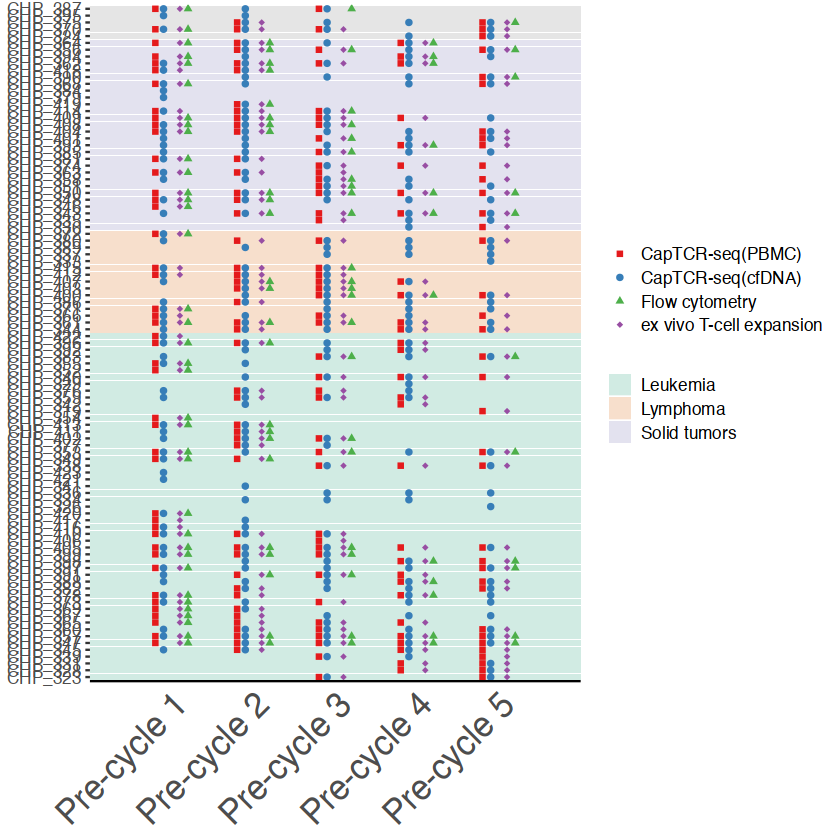

In [93]:
p0

age barplot on the right

In [94]:
group_col

Leukemia            Lymphoma        Solid tumors T-cell malignancies 
          "#1B9E77"           "#D95F02"           "#7570B3"           "#2171b5" 
                LFS              Normal 
            "black"        "light grey"

In [95]:
p1 <- ggplot(patients_cycles, aes(Patient, Age)) +
  geom_bar(stat = "identity", aes(fill = cancergroup), width = 0.8, alpha = 0.2) +
  coord_flip() +
  scale_fill_manual(values = group_col[c("Leukemia", "Lymphoma", "Solid tumors")]) +
  myplot +
  theme(
    legend.position = "none", plot.margin = unit(c(0.1, 0.1, 0.1, 0.2), "cm"),
    axis.text.y = element_blank(), axis.title.y = element_blank(), axis.title.x = element_text(size = 20),
    axis.line.x = element_line(colour = "black"), axis.text.x = element_text(size = 20)
  )

In [96]:
# Add disease type as labels
p0 <- p0 + theme(legend.position = "none") +
scale_x_discrete(labels = patients_cycles$Disease_type[match(levels(patients_cycles$Patient), patients_cycles$Patient)]) 

In [97]:
table(patients_cycles$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                 51                  15                  28                   5 

In [98]:
table(patients_cycles$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                 51                  15                  28                   5 

In [99]:
p1b <- p1 + geom_bracket(xmin = c(1, 60, 81), xmax = c(59, 80, 119), y.position = c(22, 22,22),
  label.size = 7, label = c("", "", ""), coord.flip = T) + # changes the orientaitons of labels, set without label, then add with annotate
  scale_y_continuous(expand = c(0,0), limits = c(0,35), breaks = c(5,10,15,20)) +
  annotate("text", x = c(29.5, 69.5, 99.5), y = c(22.5, 22.5,22.3), label = c("Leukemia", "Lymphoma", "Solid tumors"), size = 7, hjust = 0) + labs(y = "Age (Years)")

In [100]:
# allp <- plot_grid(p0 , p1,
# ncol = 2, rel_widths = c(1, 0.3))

In [101]:
# pdf(paste0(plotpath,"swimmerplot.pdf"), width=10, height=16)
# allp #+  theme(aspect.ratio = 4/2)
# dev.off()

In [102]:
pdf(paste0(plotpath,"swimmerplot_lgd.pdf"), width=5, height=5)

grid::grid.draw( get_legend(p0 + 
theme(legend.position = 'right', legend.box = 'vertical', legend.margin = margin(0,0,0,0)) +
guides(colour = guide_legend(override.aes = list(size=3)))) )

dev.off()

Warning message in get_plot_component(plot, "guide-box"):
"Multiple components found; returning the first one. To return all, use `return_all = TRUE`."


pdf 
  2

## Add clinical heatmap

In [103]:
table(subset_meta$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                217                  82                 140                  24 

In [104]:
head(subset_meta)

,Patient,cycle,FOLD,Disease_type,CD3,cancergroup,sampletype,TRB,Age,file
,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<chr>
302,CHP_319,5,1.2,HR ALL,NA,Leukemia,PBMC,15,1,batch2_Aug62019/mixcr/clones/CLONES_TRBCHP_319-05-PBMC-DNA.txt
320,CHP_323,3,0.0,HR ALL,NA,Leukemia,PBMC,45,1,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_323-03-PBMC-DNA.txt
322,CHP_323,5,0.0,HR ALL,NA,Leukemia,PBMC,153,1,batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_323-05-PBMC-DNA.txt
327,CHP_324,5,0.0,T-ALL,NA,T-cell malignancies,PBMC,229,12,remaining_batch_2_22April2021/mixcr/clones/CLONES_TRBCHP_324-05_PBMC-DNA.txt
346,CHP_328,4,0.0,SR ALL,NA,Leukemia,PBMC,454,7,remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-328-04-PBMC-DNA.txt
347,CHP_328,5,0.0,SR ALL,NA,Leukemia,PBMC,153,7,remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-328-05-PBMC-DNA.txt


In [105]:
clinical <- meta_div[, c("Patient","Age", "Relapse", "Transplant", "CART", "Remission", "vital_status", "LOF", "Disease_type")]

In [106]:
dim(patients_cycles)

[1] 99  5

In [108]:
clinical_unique <- clinical[!duplicated(clinical$Patient), ]

In [110]:
clinical_unique[ clinical_unique$LOF == 1,]

,Patient,Age,Relapse,Transplant,CART,Remission,vital_status,LOF,Disease_type
,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
405,CHP_340,1,0,0,0,0,0,1,ALL
463,CHP_352,17,0,0,0,0,0,1,HR ALL
478,CHP_355,3,0,0,0,0,0,1,HR ALL
484,CHP_356,9,1,0,0,0,0,1,EWS
523,CHP_364,16,1,0,0,0,0,1,OS
620,CHP_383,8,0,0,0,1,0,1,ALL
638,CHP_387,13,0,0,0,0,0,1,T-ALL
666,CHP_392,8,0,0,0,0,0,1,ALL
683,CHP_396,1,0,0,0,0,0,1,HR ALL


In [111]:
clinical_unique$Patient <- factor(clinical_unique$Patient, levels = levels(patients_cycles$Patient) )# match order of patients

In [112]:
table(clinical_unique$Relapse)


 0  1 
80 19 

In [113]:
clinical_unique[ clinical_unique$Transplant == 1,]

,Patient,Age,Relapse,Transplant,CART,Remission,vital_status,LOF,Disease_type
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
395,CHP_338,13,1,1,0,0,0,0,AML
416,CHP_342,1,1,1,0,0,1,0,AML
448,CHP_349,17,1,1,0,1,0,0,CML
468,CHP_353,6,1,1,0,1,0,0,AML
499,CHP_359,15,1,1,0,0,1,0,AML
584,CHP_376,1,1,1,0,0,1,0,AML
604,CHP_380,14,1,1,0,1,0,0,HD
762,CHP_411,16,1,1,1,1,0,0,HR ALL
771,CHP_413,19,1,1,0,1,0,0,AML


In [114]:
relapsed <- clinical_unique[ clinical_unique$Relapse == 1,]

In [115]:
table(relapsed$Disease_type)


   AML   ARMS    CML    EWS     HD HR ALL     NB     OS  T-ALL 
     6      1      1      1      1      5      1      2      1 

In [116]:
relapsed

,Patient,Age,Relapse,Transplant,CART,Remission,vital_status,LOF,Disease_type
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
302,CHP_319,1,1,0,1,0,1,0,HR ALL
395,CHP_338,13,1,1,0,0,0,0,AML
416,CHP_342,1,1,1,0,0,1,0,AML
448,CHP_349,17,1,1,0,1,0,0,CML
468,CHP_353,6,1,1,0,1,0,0,AML
484,CHP_356,9,1,0,0,0,0,1,EWS
499,CHP_359,15,1,1,0,0,1,0,AML
523,CHP_364,16,1,0,0,0,0,1,OS
543,CHP_368,1,1,0,0,1,0,0,ARMS


In [117]:
relapsed[ relapsed$Disease_type == "OS", ]

,Patient,Age,Relapse,Transplant,CART,Remission,vital_status,LOF,Disease_type
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
523,CHP_364,16,1,0,0,0,0,1,OS
657,CHP_390,5,1,0,0,1,0,0,OS


In [118]:
clinical_melt <- reshape2::melt(clinical_unique[, c("Patient",  "Relapse", "Transplant", "CART", "Remission", "vital_status", "LOF")], id.vars = "Patient")

In [119]:
clinical_melt[ is.na(clinical_melt$value), "value" ] <- 0

In [120]:
clinical_melt$value <- as.numeric(clinical_melt$value)

In [121]:
gg_hm <- ggplot(data = clinical_melt, aes(x = variable, y = Patient, fill = value)) +
  geom_tile() +
  myplot +
  myaxis +
  theme(
    legend.position = "none", axis.title = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
    plot.margin = unit(c(0.1, 0.2, 1, 1), "cm"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.5)
  ) +
  scale_fill_gradient(low = "white", high = "black")


Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


In [122]:
pdf(paste0(plotpath, "swimmerplot_clinical.pdf"), width = 12, height = 16)
plot_grid(p0, gg_hm, p1b, ncol = 3, align = "h", rel_widths = c(3, 1, 1.2))
dev.off()


pdf 
  2

Descriptives for main text

In [123]:
tmp <- meta_div

In [124]:
length(table(tmp$Patient))
table(tmp$sampletype, useNA = "always")

[1] 99


 PBMC cfDNA  <NA> 
  197   266     0 

In [125]:
myfreq <- as.data.frame(table(tmp$cancergroup, tmp$Patient) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [126]:
head(myfreq)

,Var1,Var2,Freq
,<chr>,<chr>,<int>
1,Leukemia,CHP_319,1
5,Leukemia,CHP_323,4
12,T-cell malignancies,CHP_324,3
13,Leukemia,CHP_326,1
17,Leukemia,CHP_328,3
21,Leukemia,CHP_329,1


In [127]:
dim(myfreq)

[1] 99  3

In [128]:
table(myfreq$Var1)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                 51                  15                  28                   5 

In [129]:
myfreq <- as.data.frame(table(tmp$Disease_type, tmp$Patient) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [130]:
table(myfreq$Var1)


  ALCL    ALL    AML   ARMS     BL    BLL    CML  DLBCL   ERMS    EWS     HB 
     1     21     10      1      4      2      3      2      3      6      3 
    HD HR ALL  MS NB     NB     OS  PMBCL SR ALL  T-ALL  WILMS 
     6     14      1      4      9      1      3      4      1 

In [131]:
rm(tmp)

In [132]:
# remove ffpe samples
# column sampletype includes NA (they are flow data without TCR), if using which ==, it will remove all NA
tmp <- meta_div

#tmp <- tmp[ which(tmp$sampletype == "PBMC"),]

myfreq <- as.data.frame(table(tmp$cancergroup[!is.na(tmp$CD3)], tmp$Patient[!is.na(tmp$CD3)]) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [133]:
dim(myfreq)

[1] 68  3

In [134]:
table(myfreq$Var1)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                 30                   9                  25                   4 

In [135]:
tmp <- meta_div[ which(meta_div$sampletype == "PBMC"),]

In [136]:
length(unique(tmp$Patient[ !is.na(tmp$CD3) ]))

[1] 58

In [137]:
length(tmp$Patient[ !is.na(tmp$CD3) ])

[1] 106

In [138]:
dim(tmp[ !is.na(tmp$FOLD), ])

[1] 196  67

In [141]:
table(meta_div$sampletype[!is.na(meta_div$TRB)])


 PBMC cfDNA 
  197   266 